In [138]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
from itertools import product
from scipy.signal import firwin, lfilter
from commpy.modulation import PSKModem, QAMModem
from commpy.filters import rrcosfilter
from brian2 import us, ms
from utils.modulator import modulate, AsynchronousDeltaModulator
from utils.plotting import plot_sample

In [139]:
def round_complex(x):
    return np.round(x.real, decimals=2)+np.round(x.imag, decimals=2)*1j

# Pipeline
1. convert string to bit stream
2. baseband I/Q modulation
3. modulate I/Q samples to spikes trains

# 1) String to bitstream conversion

In [140]:
input_string = "test"
bits_string = ''.join(format(x, 'b') for x in bytearray(input_string, encoding='utf-8'))
input_bits = np.array([int(b) for b in bits_string])
print("{} ---> {}".format(input_string, input_bits))

test ---> [1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0]


# 2) Baseband I/Q modulation

![Baseband IQ modulation](../images/baseband-iq-modulation.png)
([source](https://dspillustrations.com/pages/posts/misc/baseband-up-and-downconversion-and-iq-modulation.html))

Select a phase-shift-keying (PSK) or quadrature-amplitude (QAM) digital modulation and set the size $m$ of the constellation:
1. $\text{BPSK} \rightarrow m=2$
2. $\text{QPSK} \rightarrow m=4$
3. $\text{8PSK} \rightarrow m=8$
4. $\text{QAM16} \rightarrow m=16$
5. $\text{QAM64} \rightarrow m=64$

In [141]:
m = 4
modem = PSKModem(m)
#modem = QAMModem(m)

_Fix for rounding bug in Commpy modem module_

In [142]:
modem.constellation = round_complex(np.array(modem.constellation))

In [143]:
bits_symbols = list(product([0, 1], repeat=modem.num_bits_symbol))
baseband_symbols = modem.modulate(np.array(bits_symbols).flatten())

(-3.5, 3.5)

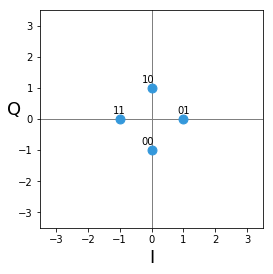

In [144]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlabel("I", fontsize=18)
ax.set_ylabel("Q", fontsize=18, rotation=0)
ax.axhline(0, color="gray", linewidth=1, zorder=0.0)
ax.axvline(0, color="gray", linewidth=1, zorder=0.0)
ax.scatter(baseband_symbols.real, baseband_symbols.imag, c='#3498db', s=80)
for (i, s) in enumerate(bits_symbols):
    x, y = (baseband_symbols[i].real, baseband_symbols[i].imag)
    if x==0:
        sx = -0.12
    else:
        sx = 0.0
    if y==0:
        sy = 0.07
    else:
        sy = 0.0
    if np.abs(x)<1 and np.abs(y)<1:
        sy = 0.07
    ax.text(x+sx, y+0.1, "{}".format(''.join(map(str, s))), horizontalalignment='center', verticalalignment='bottom')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylim((-3.5, 3.5))
ax.set_xlim((-3.5, 3.5))
#plt.savefig("images/QAM16-constellation.pdf", bbox=plt.tight_layout())

## T1
Map bits to baseband symbols according to the corresponding constellation diagram.

In [145]:
dk = modem.modulate(input_bits)
print("input bits --> {}".format(dk))

input bits --> [-1.+0.j  0.+1.j  0.+1.j  1.+0.j  0.+1.j  1.+0.j  1.+0.j -1.+0.j  0.+1.j
  1.+0.j -1.+0.j -1.+0.j  1.+0.j  0.-1.j]


In [146]:
Ts = 1e-3                           # 1 ms symbol spacing
N = len(dk)                         # number of transmitted baseband symbols
t_symbols = Ts * np.arange(N)       # time instants of the baseband symbols

<StemContainer object of 3 artists>

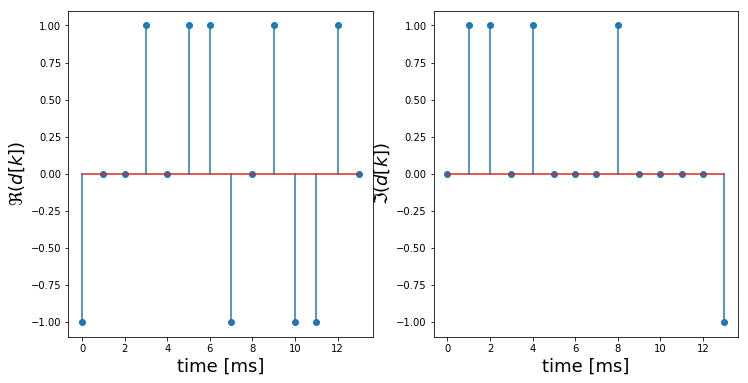

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_ylabel(r"$\Re(d[k])$", fontsize=18)
ax1.set_xlabel("time [ms]", fontsize=18)
ax1.stem(t_symbols/ms, dk.real)
ax2.set_ylabel(r"$\Im(d[k])$", fontsize=18)
ax2.set_xlabel("time [ms]", fontsize=18)
ax2.stem(t_symbols/ms, dk.imag)

## T2

Digital to analog conversion happens by first weighting a Dirac comb function $x(t)$ with the baseband symbols $d[k]$

$$
x(t) = \sum_{k=-\infty}^{+\infty}d[k]\delta(t-kT_s)
$$

where $k$ is the symbol index and $T_s$ is the symbol spacing, i.e. the time between two consecutive symbols.

In [148]:
Fs = int(6e4)                       # 60kHz, the sampling frequency we use for the discrete simulation of analog signals 
ups = int(Ts*Fs)                    # number of samples per symbol in the "analog" domain

In [149]:
x = np.zeros(ups*N, dtype='complex')
x[::ups] = dk                       # every ups samples, a symbol is inserted into the sequence
t_x = np.arange(len(x))/Fs

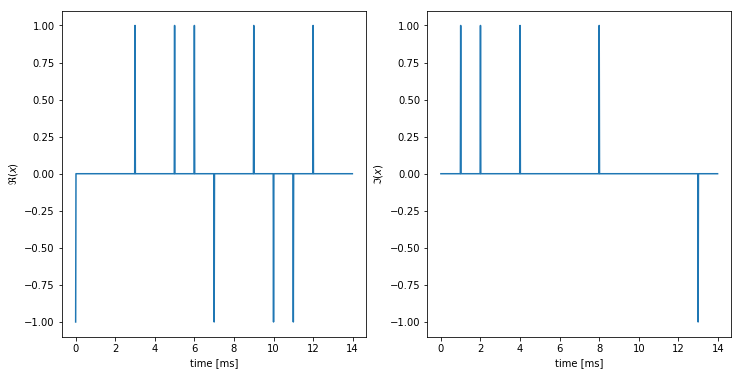

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_ylabel(r"$\Re(x)$")
ax1.set_xlabel("time [ms]")
ax1.plot(t_x/ms, x.real)
ax2.set_ylabel(r"$\Im(x)$")
ax2.set_xlabel("time [ms]")
ax2.plot(t_x/ms, x.imag)

## T3

The next step consists in convolving the Dirac comb function $x(t)$ with a pulse shaping filter $g(t)$

$$
u(t) = g(t) \ast x(t) = \sum_{k=-\infty}^{+\infty}d[k]g(t-kT_s).
$$

Here we use a raised-root-cosine (RRC) filter that spans 3 baseband sample to the left and to the right. This means the fitler introduces a delay $t_0 = 3T_s$

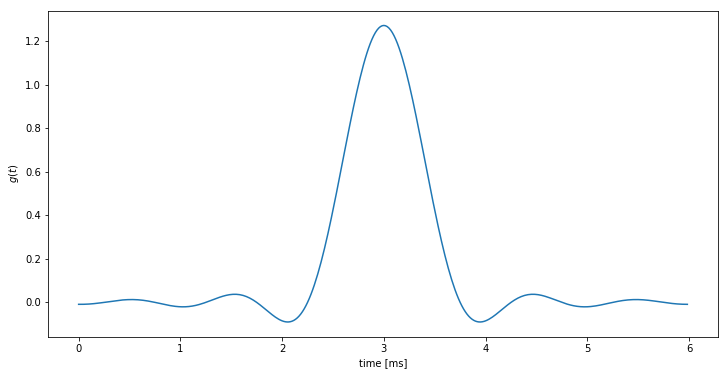

In [151]:
t0 = 3*Ts  
_, rrc = rrcosfilter(N=int(2*t0*Fs), alpha=1,Ts=Ts, Fs=Fs) # N is the number of samples in the filter
t_rrc = np.arange(len(rrc)) / Fs                           # the time points that correspond to the filter values
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel(r"$g(t)$")
ax.set_xlabel("time [ms]")
ax.plot(t_rrc/ms, rrc)

In [152]:
u = np.convolve(x, rrc)
t_u = np.arange(len(u))/Fs

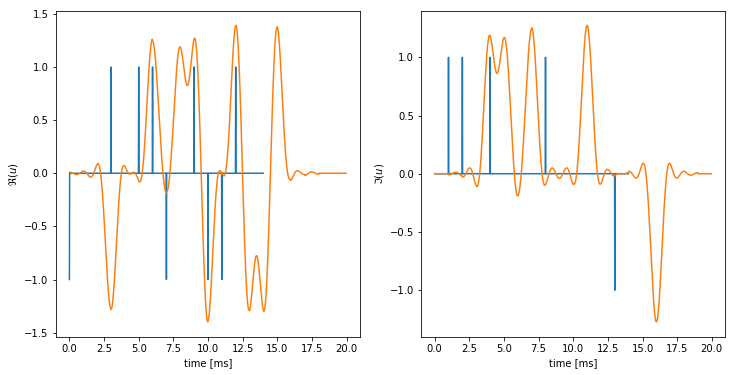

In [153]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_ylabel(r"$\Re(u)$")
ax1.set_xlabel("time [ms]")
ax1.plot((t_x)/ms, x.real, label='$x(t)$') # artificial extra delay for the baseband samples
ax1.plot(t_u/ms, u.real, label='$u(t)$')
ax2.set_ylabel(r"$\Im(u)$")
ax2.set_xlabel("time [ms]")
ax2.plot((t_x)/ms, x.imag)
ax2.plot(t_u/ms, u.imag)

## T4-6

The real and imaginary components of $u(t)$ are also called in-phase (I) and quadrature (Q) component respectively

$$
i(t) = \Re(u) \\
q(t) = \Im(u). 
$$


These real valued signals are used to modulate the amplitude of the two sinusoidal functions with frequency $f_c$ that compose the carrier signal. Altogether we have

$$
s(t) = i_{up}(t) + q_{up}(t)
$$

where

$$
i_{up}(t) = i(t) \cdot \cos(2\pi f_c t) \\
q_{up}(t) = -q(t) \cdot \sin(2\pi f_c t). 
$$

In [154]:
fc = int(3e3)                       # 3kHz carrier frequency

In [172]:
i = u.real
q = u.imag
iup = i * np.cos(2*np.pi*t_u*fc)  
qup = q * -np.sin(2*np.pi*t_u*fc)

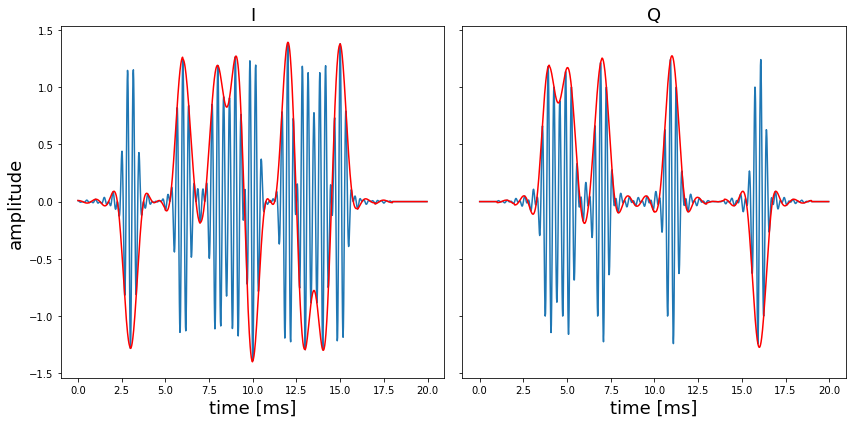

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax1.set_ylabel("amplitude", fontsize=18)
ax1.set_xlabel("time [ms]", fontsize=18)
ax1.plot(t_u/ms, iup, label='$I_{up}(t)$')
ax1.plot(t_u/ms, i, 'r', label='$I(t)$')
ax1.set_title("I", fontsize=18)
#ax1.legend(loc="upper right")
ax2.set_xlabel("time [ms]", fontsize=18)
ax2.plot(t_u/ms, qup, label='$IQ_{up}(t)$')
ax2.plot(t_u/ms, q, 'r', label='$I/Q(t)$')
#ax2.legend(loc="upper right", fontsize=18)
ax2.set_title("Q", fontsize=18)
plt.savefig("images/IQ-example.pdf", bbox=plt.tight_layout())

In [157]:
s = iup + qup

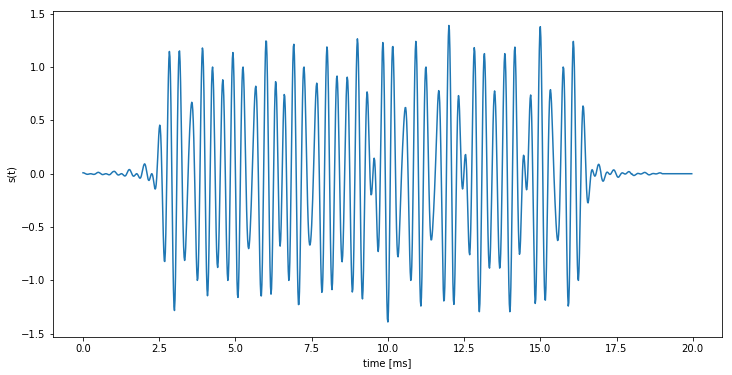

In [158]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel("s(t)")
ax.set_xlabel("time [ms]")
ax.plot(t_u/ms, s)

## R1

On the receiving end the real values signal $s(t)$ is multiplied with two sinusoidal functions of frequency $f_c$ to obtain the down-converted I and Q components

$$
i_{down}(t) = s(t) \cdot \cos(2\pi f_c t) \\
q_{down}(t) = -s(t) \cdot \sin(2\pi f_c t). 
$$

In [159]:
idown = s * np.cos(2*np.pi*-fc*t_u) 
qdown = s * -np.sin(2*np.pi*fc*t_u)

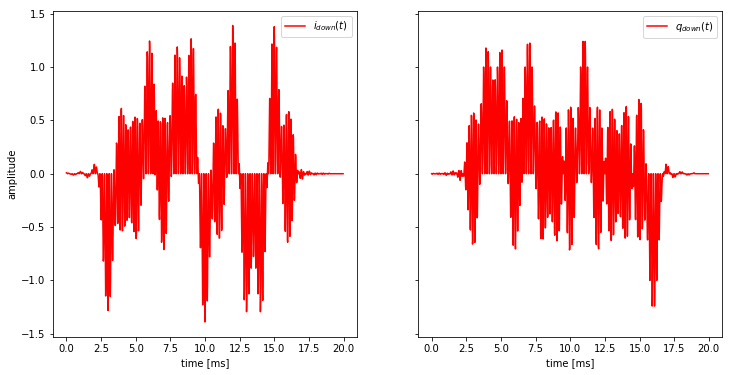

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax1.set_ylabel("amplitude")
ax1.set_xlabel("time [ms]")
ax1.plot(t_u/ms, idown, 'r', label='$i_{down}(t)$')
ax1.legend(loc="upper right")
ax2.set_xlabel("time [ms]")
ax2.plot(t_u/ms, qdown, 'r', label='$q_{down}(t)$')
ax2.legend(loc="upper right")

## R2

To obtain the central frequency of the down-converted components a lowpass filter is used. This allows us to reject the images of the signal around $f=2f_c$. The filtered components are then

$$
i_{down, LP}(t) = i_{down}(t)\ast LP(t) \\
q_{down, LP}(t) = q_{down}(t)\ast LP(t).
$$

(-70, 10)

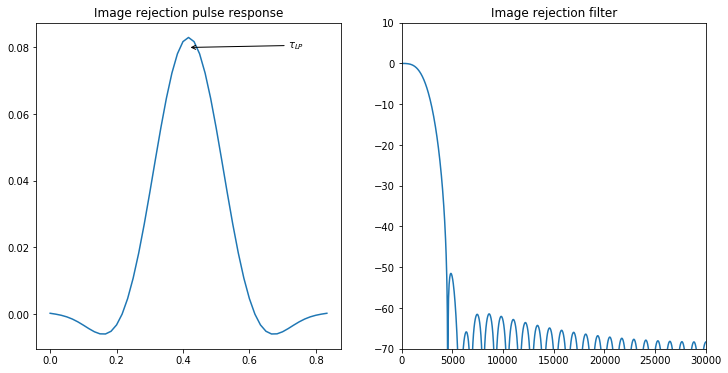

In [161]:
BN = 1/(2*Ts )                                   # the Nyquist bandwidth of the baseband signal.
cutoff = 5*BN                                    # arbitrary design parameters
lowpass_order = 51   
lowpass_delay = (lowpass_order // 2)/Fs          # a lowpass of order N delays the signal by N/2 samples (see plot)
lowpass = firwin(lowpass_order, cutoff/(Fs/2))

# calculate frequency response of filter
t_lp = np.arange(len(lowpass))/Fs
f_lp = np.linspace(-Fs/2, Fs/2, 2048, endpoint=False)
H = np.fft.fftshift(np.fft.fft(lowpass, 2048))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title("Image rejection pulse response")
ax1.plot(t_lp/Ts, lowpass)
ax1.annotate(r'$\tau_{LP}$', xy=(lowpass_delay/Ts,0.08), xytext=(lowpass_delay/Ts+0.3, 0.08), arrowprops=dict(arrowstyle='->'))
ax2.set_title("Image rejection filter")
ax2.plot(f_lp, 20*np.log10(abs(H)))
ax2.set_xlim((0, Fs/2))
ax2.set_ylim((-70, 10))

The lowpass filter introduces a delay $\tau_{LP}$ between the up and down-converted I and Q components.

In [162]:
idown_lp = lfilter(lowpass, 1, idown)
qdown_lp = lfilter(lowpass, 1, qdown)

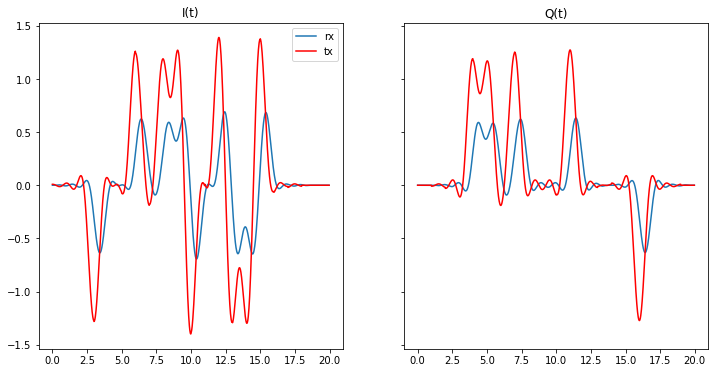

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax1.set_title("I(t)")
ax1.plot(t_u/ms, idown_lp, label='rx')
ax1.plot(t_u/ms, i, 'r', label='tx')
ax1.legend(loc='best')
ax2.set_title("Q(t)")
ax2.plot(t_u/ms, qdown_lp, label='rx')
ax2.plot(t_u/ms, q, 'r', label='tx')

Apart from a delay $t_0+\tau_{LP}$ and an amplitude attenuation, the up and down-converted I and Q components look identical. In a real world scenario this will not be the case, since various phenomena can affect the communication channel, distoring the transmitted signal $s(t)$.

In the following steps of the pipeline we use the down-converted, lowpass filtered I and Q components with a scaling factor of 2. From this point on a sample refers to a tuple

$$
S(t) = 2\cdot(i_{down, LP}(t), q_{down, LP}(t))
$$

In [164]:
sample = np.empty((2, len(t_u)))
sample[0, :] = idown_lp
sample[1, :] = qdown_lp
sample.shape

(2, 1199)

# 3) Spike train modulation

In order to be able to stimulate the reservoir implemented on the neuromorphic hardware, the I and Q components of the sample need to be converted into spike trains. This is achieved using an asynchronous delta modulator. For each component we define a separate instance of the delta modulator, which converts an analog signal into a set of 2 spike trains. These are referred to as UP and DN channel. A spike is generated in the UP (DN) channel when the signal increases (decreases) by a certain amount compared to a reference value, which is set to the amplitude of the signal at the previous time of spiking. The UP and DN thresholds thus trail the signal. From a sample S with I and Q components we obtain 4 spike trains, representing UP and DN channels for each component.

In [165]:
settings = {
    'time_sample': t_u,
    'thrup': 0.1,
    'thrdn': 0.1,
    'resampling_factor': 10
}

In [166]:
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]

In [167]:
modulators[0].interpolate(settings['time_sample'], sample[0, :])
modulators[1].interpolate(settings['time_sample'], sample[1, :])
modulators[0].encode()
modulators[1].encode()
indices = []
times = []
time_stim = np.linspace(t_u.min(), t_u.max(), num=len(t_u)*settings['resampling_factor'], endpoint=True)
for i in range(modulators[0].time_length):
    if modulators[0].up[i]:
        indices.append(0)
        times.append(time_stim[i])
    if modulators[0].dn[i]:
        indices.append(1)
        times.append(time_stim[i])
    if modulators[1].up[i]:
        indices.append(2)
        times.append(time_stim[i])
    if modulators[1].dn[i]:
        indices.append(3)
        times.append(time_stim[i])
signal = np.array([modulators[0].vin, modulators[1].vin])
indices = np.array(indices)
times = np.array(times)

In order to appropriately train the readout, each sample needs to be labeled. Since the sets of baseband symbols for different modulations overlap, we devise a two step process in order to correctly classify incoming signals. The first step consists in extracting the baseband symbols from the incoming sampled I and Q components. After that, statistics about the occurence frequency for different baseband symbols in a given time slot can be used to provide a probabilistic estimate of the modulation of the incoming signal.

The ground truth for the first step can be generated using the baseband symbols above and mapping each to a unique integer value, which would then be further translated into a stimulation frequency for the corresponding readout neuron in the reservoir. For example, in the case of QPSK modulation, which has 4 baseband symbols, the mapping would be

$$
\begin{align}
L:~ &\mathbb{C} &\rightarrow ~&\mathbb{N} \\
0&-1i &\rightarrow ~&0 \\
1&+0i &\rightarrow ~&1 \\
0&+1i &\rightarrow ~&2 \\
-1&+0i &\rightarrow ~&3 .
\end{align}
$$



In [168]:
labels = list(map(lambda s: np.where(modem.constellation==s)[0][0], dk))
print("labels --> {}".format(labels))

labels --> [3, 2, 2, 1, 2, 1, 1, 3, 2, 1, 3, 3, 1, 0]


In [169]:
labels_signal = np.zeros(ups*N)
labels_times = np.zeros(N+1)
for (i, y) in enumerate(labels):
    labels_signal[i*ups:(i+1)*ups] = y
    labels_times[i+1] = (i+1)*Ts
delay = t0+lowpass_delay
t_l = np.arange(len(labels_signal))/Fs+delay-Ts/2
labels_times += delay-Ts/2

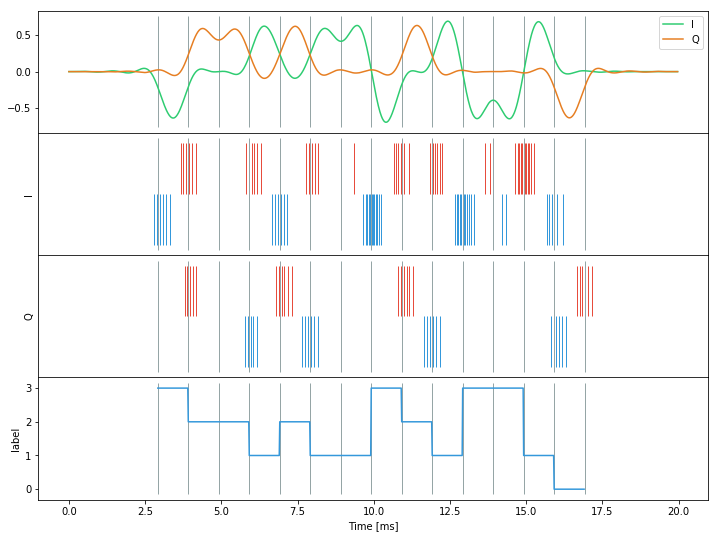

In [170]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(4, 1, wspace=0.0, hspace=0.0)
ax1 = plt.Subplot(fig, grid[0])
ax1.plot(time_stim/ms, signal[0, :], color='#2ecc71', label='I')
ax1.plot(time_stim/ms, signal[1, :], color='#e67e22', label='Q')
ax1.legend(loc='upper right')
ax1.vlines(labels_times/ms, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], colors="#95a5a6", linewidth=1)
ax2 = plt.Subplot(fig, grid[1], sharex=ax1)
ax2.set_yticks([])
ax2.set_ylabel('I')
ax2.vlines(times[indices==0]/ms, ymin=0.0, ymax=1.0, colors='#e74c3c', linewidth=1)
ax2.vlines(times[indices==1]/ms, ymin=-1.0, ymax=0.0, colors='#3498db', linewidth=1)
ax2.vlines(labels_times/ms, ymin=ax2.get_ylim()[0], ymax=ax2.get_ylim()[1], colors="#95a5a6", linewidth=1)
ax3 = plt.Subplot(fig, grid[2], sharex=ax1)
ax3.set_yticks([])
ax3.set_ylabel('Q')
ax3.vlines(times[indices==2]/ms, ymin=0.0, ymax=1.0, colors='#e74c3c', linewidth=1)
ax3.vlines(times[indices==3]/ms, ymin=-1.0, ymax=0.0, colors='#3498db', linewidth=1)
ax3.vlines(labels_times/ms, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], colors="#95a5a6", linewidth=1)
ax4 = plt.Subplot(fig, grid[3], sharex=ax1)
ax4.plot(t_l/ms, labels_signal, color="#3498db")
ax4.yaxis.set_major_locator(plt.MultipleLocator(1))
ax4.set_ylabel("label")
ax4.set_xlabel(r'Time [ms]')
ax4.vlines(labels_times/ms, ymin=ax4.get_ylim()[0], ymax=ax4.get_ylim()[1], colors="#95a5a6", linewidth=1)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)
fig.add_subplot(ax4)